In [1]:
# packages
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# models
rf_clf = RandomForestClassifier(n_estimators=1666, max_features="auto", min_samples_split=2, min_samples_leaf=2,
                                max_depth=20, bootstrap=True, n_jobs=1)

# load and organize Wisconsin Breast Cancer Data
data = load_breast_cancer()
label_names = data['target_names']
labels = data['target']
feature_names = data['feature_names']
features = data['data']

In [2]:
# data splits
X_tng, X_val, y_tng, y_val = train_test_split(features, labels, test_size=0.33, random_state=42)

print(X_tng.shape)
print(X_val.shape)

(381, 30)
(188, 30)


In [3]:
# fit classifiers and measure AUC
clf = rf_clf.fit(X_tng, y_tng)

pred_rf = clf.predict_proba(X_val)
score_rf = roc_auc_score(y_val,pred_rf[:,1])
print(score_rf, 'Random Forest AUC')


0.9954360429258665 Random Forest AUC


In [4]:
# IMPORTANT: add a 'Customer' column to the val/test/score data
X_val = pd.DataFrame(X_val)
X_val['Customer'] = X_val.index
print(X_val.shape)

(188, 31)


In [5]:
# SHAP Waterfall artifact for vMS AWS and others
#
# Warning: Scoring df must have Customer ID column named "Customer". Code example is below:
# X_df.reset_index(drop=True, inplace=True)
# Cust_df.reset_index(drop=True, inplace=True)
# X_df["Customer"]=Cust_df
# End of example
#
# Inputs are: 1) Trained model (object) and data (dataframe),
# 2) Scoring features indexed with Customer ID (dataframe),
# 3) Clients for Comparison (strings), and 4) Number of Important Features desired (Integer)
# Output is a waterfall chart

def ShapWaterFall(Model, X_tng, X_sc, cust1, cust2, num_feature):
    import pandas as pd
    import numpy as np
    import shap
    import matplotlib.pyplot as plt
    import waterfall_chart

    # label names until we figure out how sql alchemy can fully work on Linux
    clients_to_show = [cust1, cust2]

    # Data Frame management
    if isinstance(X_sc, pd.DataFrame):
        X_v = X_sc
    else:
        X_v = pd.DataFrame(X_sc)
    if isinstance(X_tng, pd.DataFrame):
        X_t = X_tng
    else:
        X_t = pd.DataFrame(X_tng)

    # SHAP Values
    explainer = shap.TreeExplainer(Model, shap.sample(X_t, 100))

    # Data
    data_for_prediction1 = X_v[(X_v.Customer == clients_to_show[0])]
    data_for_prediction1 = data_for_prediction1.drop('Customer', 1)
    data_for_prediction2 = X_v[(X_v.Customer == clients_to_show[1])]
    data_for_prediction2 = data_for_prediction2.drop('Customer', 1)

    # Insert a binary option to ensure order goes from lower to higher propensity
    if Model.predict_proba(data_for_prediction1)[:, 1] <= Model.predict_proba(data_for_prediction2)[:, 1]:
        frames = [data_for_prediction1, data_for_prediction2]
    else:
        frames = [data_for_prediction2, data_for_prediction1]
        clients_to_show = [cust2, cust1]

    # Computations for Waterfall Chart
    data_for_prediction = pd.concat(frames)
    data_for_prediction = pd.DataFrame(data_for_prediction)

    # data_for_prediction = data_for_prediction.drop('Customer', 1)
    feature_names = data_for_prediction.columns.values
    shap_values = explainer.shap_values(data_for_prediction)
    Feat_contrib = pd.DataFrame(list(map(np.ravel, shap_values[1])), columns=feature_names)
    counter1 = len(Feat_contrib.columns)
    Feat_contrib['base_line_diff'] = Feat_contrib.sum(axis=1)
    Feat_contrib['prediction'] = Model.predict_proba(data_for_prediction)[:, 1]
    Feat_contrib['baseline'] = Feat_contrib.prediction - Feat_contrib.base_line_diff
    diff_df = pd.DataFrame(
        {'features': Feat_contrib.diff().iloc[1, :].index, 'contrib': Feat_contrib.diff().iloc[1, :].values})[
              :counter1].sort_values(by='contrib', ascending=False).reset_index(drop=True)

    # Waterfall Chart
    plt.rcParams.update({'figure.figsize': (16, 12), 'figure.dpi': 100})
    xlist = [[clients_to_show[0], 'Other {a} Features'.format(a=counter1-num_feature)], diff_df.features.tolist()[:num_feature]]
    xlist = [item for sublist in xlist for item in sublist]
    ylist = [[np.round(Feat_contrib.prediction[0], 6), np.round(diff_df.contrib[num_feature:].sum(), 6)],
             np.round(diff_df.contrib.tolist(), 6)[:num_feature]]
    ylist = [item for sublist in ylist for item in sublist]
    waterfall_df = pd.DataFrame({"x_values": xlist, 'y_values': ylist})
    plt.rcParams.update({'figure.figsize': (16, 12), 'figure.dpi': 100})
    plot = waterfall_chart.plot(xlist, ylist, net_label=str(clients_to_show[1]), rotation_value=90, formatting='{:,.3f}')
    plot.show()
    

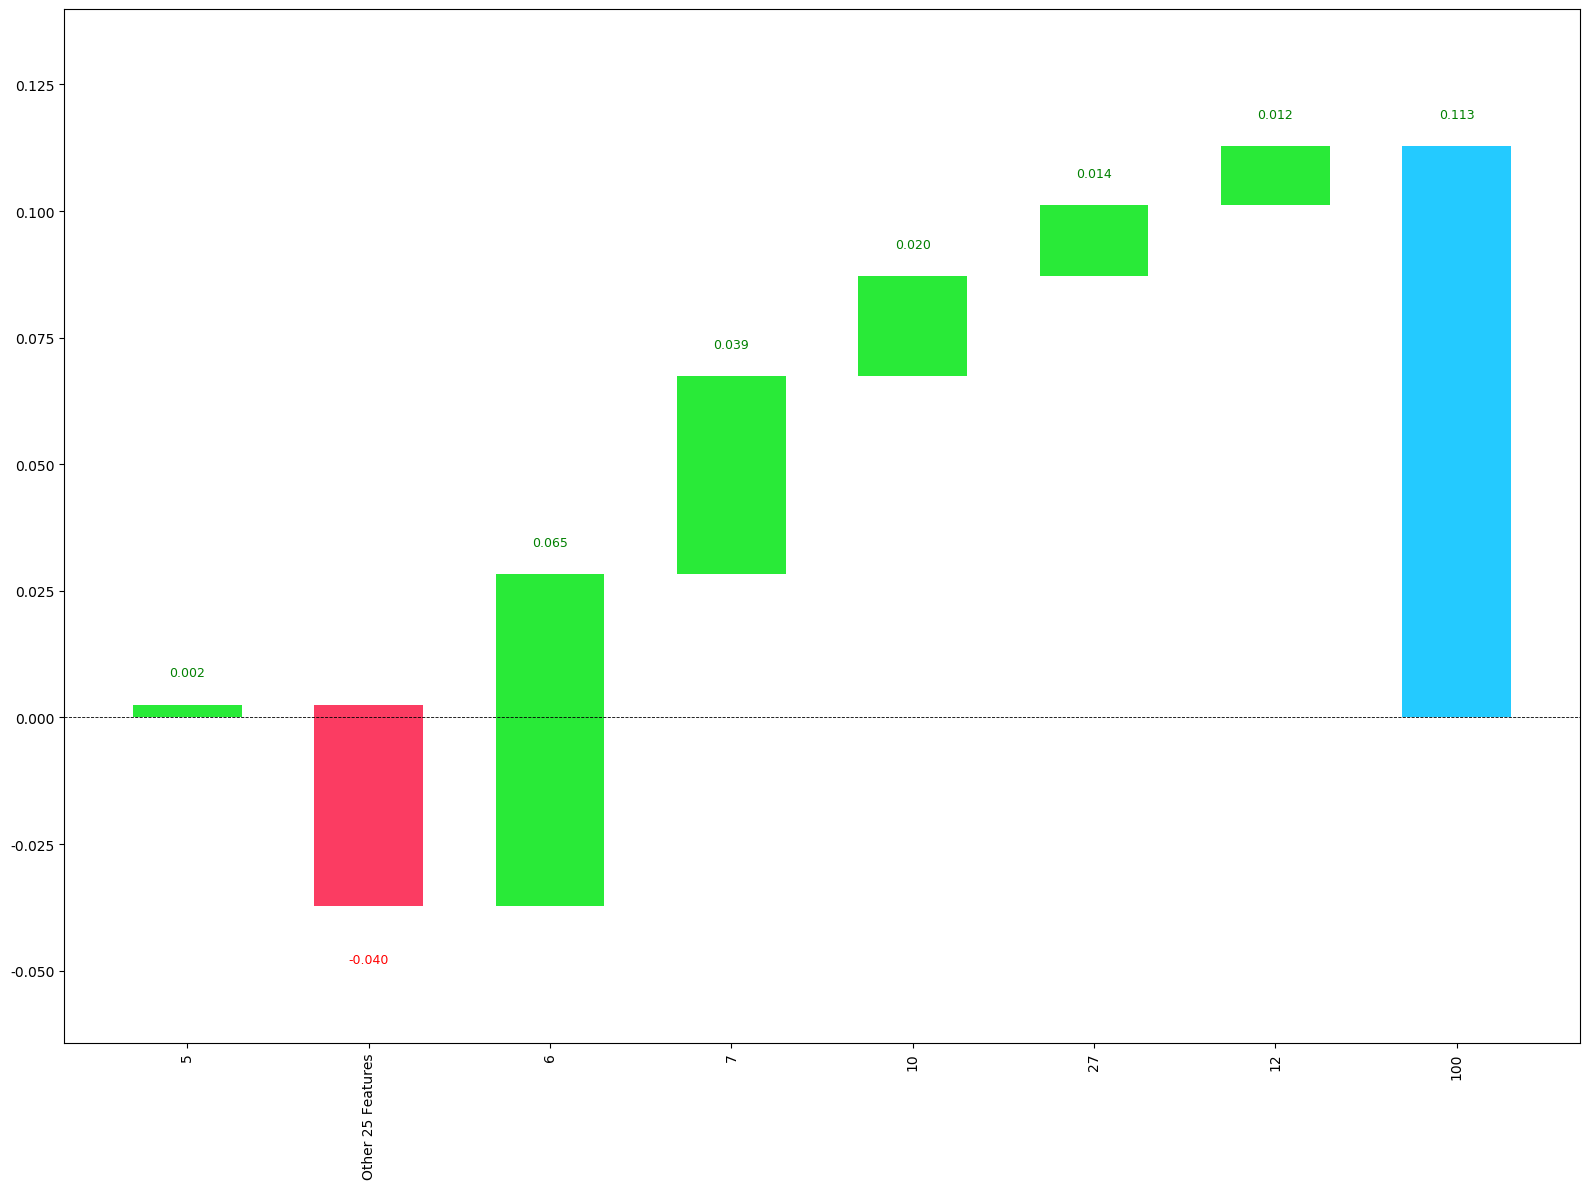

In [6]:
ShapWaterFall(clf, X_tng, X_val, 5, 100, 5)

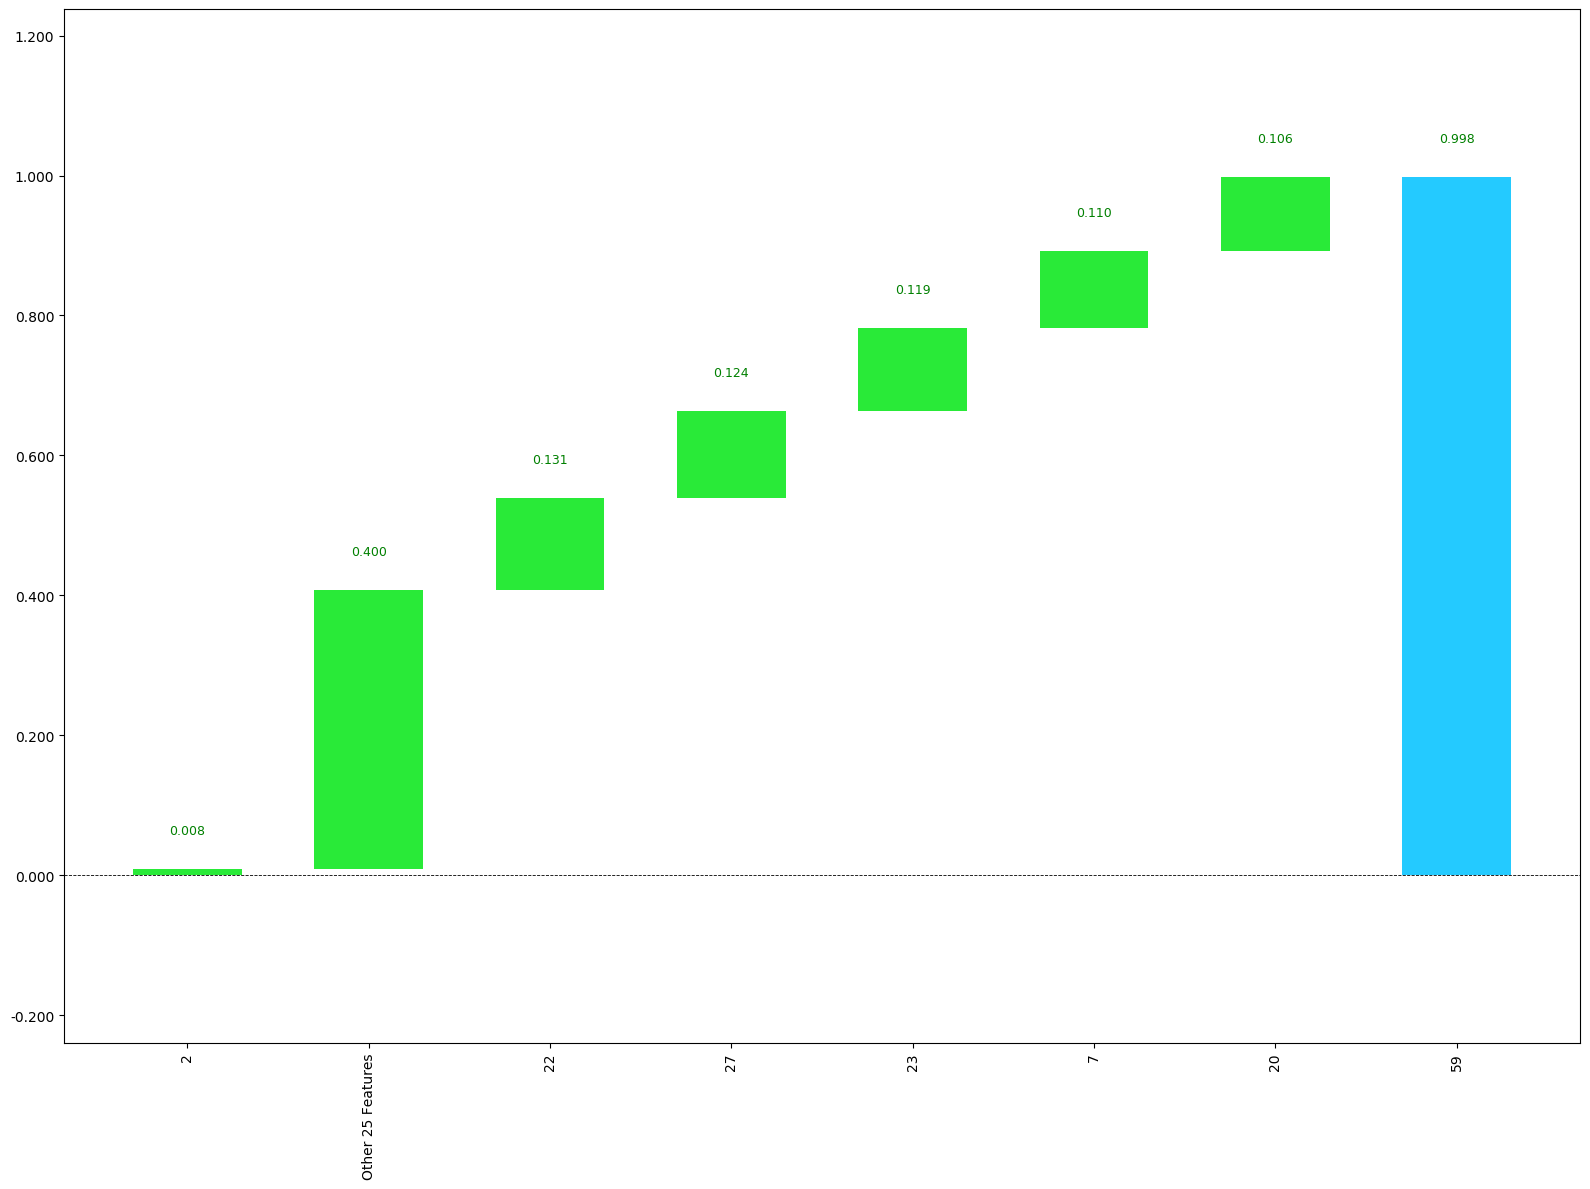

In [7]:
ShapWaterFall(clf, X_tng, X_val, 2, 59, 5)